In [1]:
import math
import os
import natsort
import skimage
import numpy as np
import pandas as pd
from natsort import natsorted, ns
from skimage import io, color
from matplotlib import pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC, l1_min_c
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import scipy.misc
from scipy import ndimage
import seaborn as sns

%matplotlib inline 

## Code that only Existed this Generation
    Initial Investigation of how to Crop on Black & White Counts
    Individual Plotting of Crop Locations using 1D Ticks
    SGDClassifier Model
    Pipeline Functionality: Standard Scalar
    GridSearch on L2 Hinge Model

In [2]:
#Directory
data = 'HPTLCRaw\\'

### Color Import

In [3]:
# Import images as Color for visual identification purposes
list_files_co = os.listdir(data)
list_files_co = natsorted(list_files_co)
image_list_co = []
for filename in list_files_co:
    image_list_co.append(io.imread(data+filename)[:,:,:3])

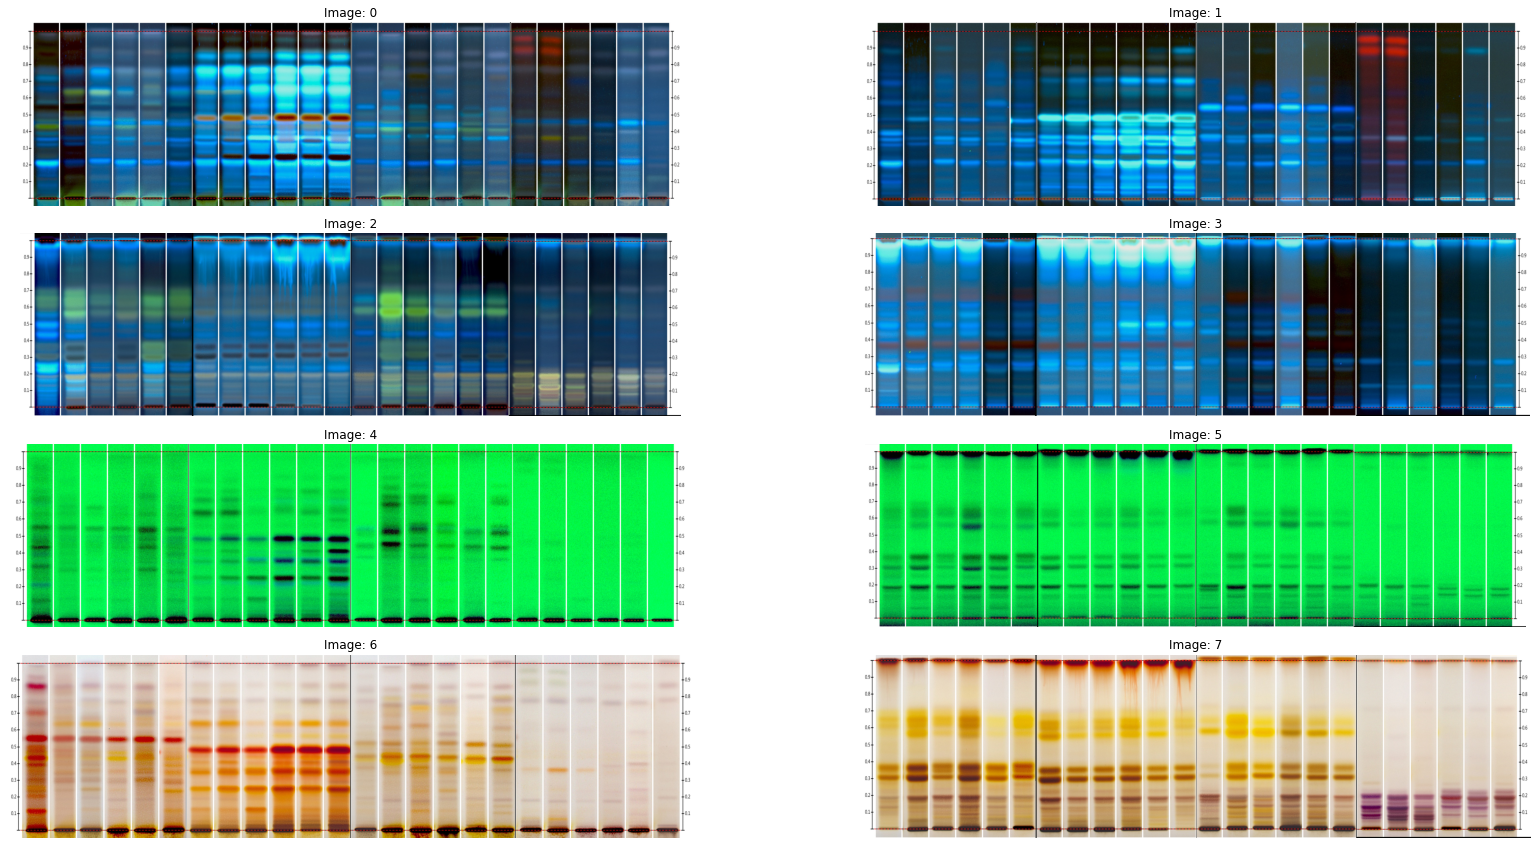

In [4]:
# Plot Every File in Directory as Colored Image
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(image_list_co):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    sub.set_title('Image: '+str(i))
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=0.15)

### Grey Scale Import

In [5]:
# Import Images as Grey Scale
list_files = os.listdir(data)
list_files = natsorted(list_files)
image_list = []
for filename in list_files:
    image_list.append(color.rgb2gray(io.imread(data+filename)[:,:,:3]))

In [6]:
# Crop all Images
cropped_img_list = []
for image in image_list:
    cropped_img_list.append(image[70:1100,96:-84])

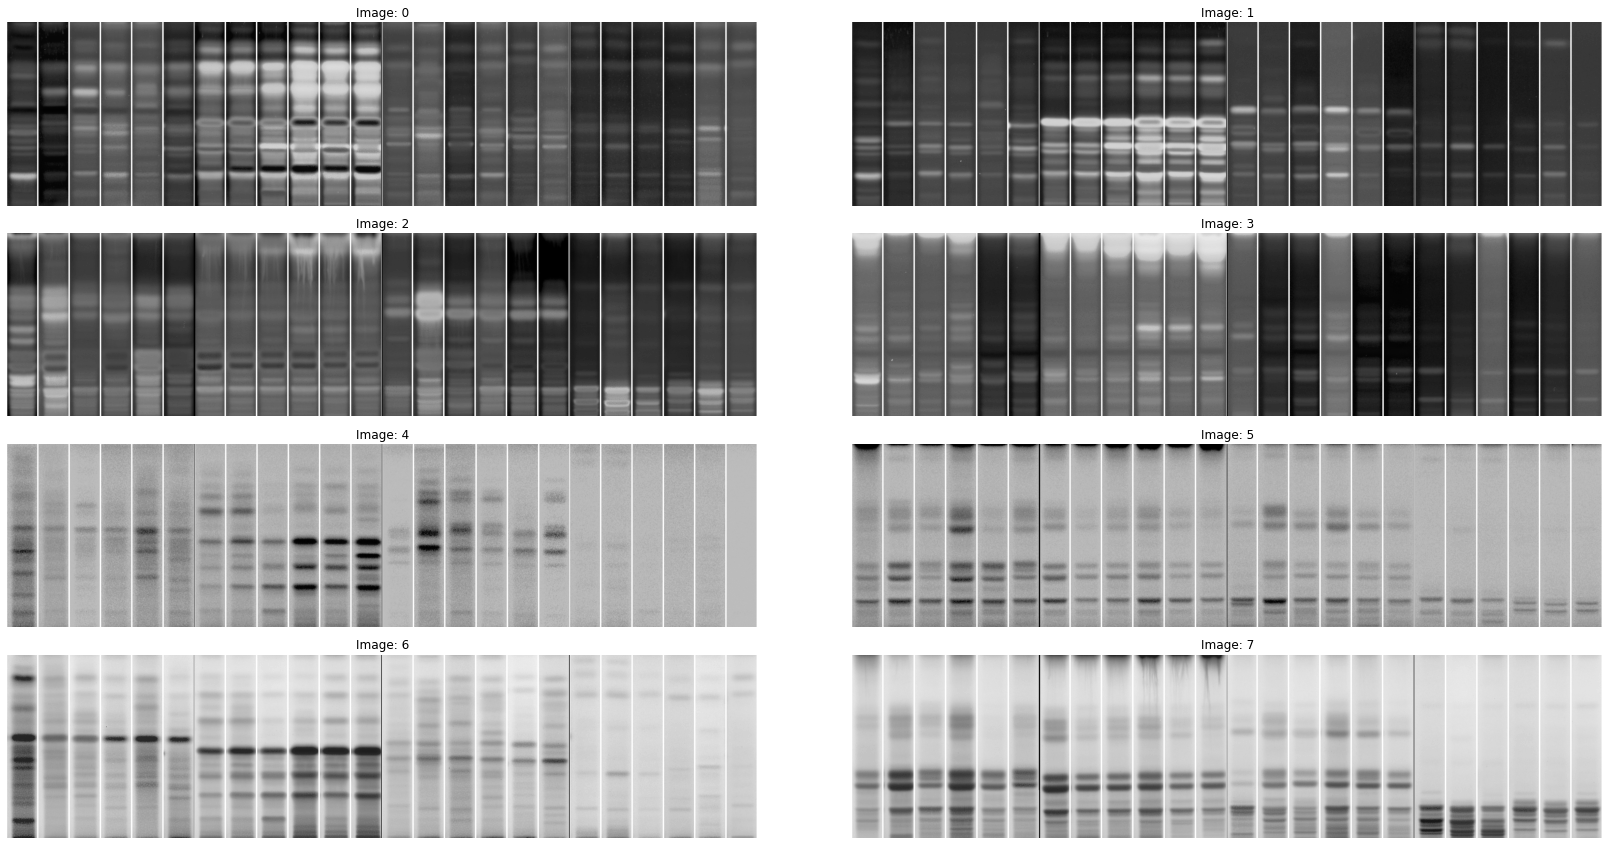

In [7]:
# Plot Every Cropped File as a Greyscale Image
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(cropped_img_list):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    sub.set_title('Image: '+str(i))
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=.15)

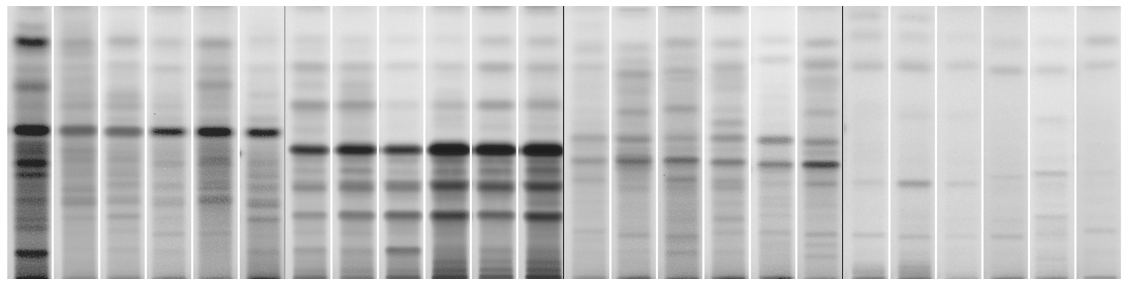

In [8]:
# Utility Code: Useful for viewing 1 image
crop_img = cropped_img_list[-2]
plt.figure(figsize = (20,10))
plt.axis('off')
plt.imshow(crop_img,cmap='gray')

In [9]:
# Verifying Shape of each Cropped Image
for i in range(len(cropped_img_list)):
    print(np.shape(cropped_img_list[i]))

(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)


#### Investigating how to determine Crop locations

##### Determing locations of white space in between strips -> get count of pixels above value .8 in each column

In [10]:
# Utility Code: Individual count of pixels in a column with a lot of high (white) values

# det_crops = pd.DataFrame(cropped_img_list[3])
# col_hi_cnt = det_crops[det_crops>.8].count()
# print(col_hi_cnt.max())
# print(col_hi_cnt.min())

In [11]:
# Utility Code: Individual plot of count of each columns number of white pixels

# plt.figure(figsize = (80,10))
# col_hi_cnt.plot.bar()
# plt.xticks([])

##### Determing locations of black space in between strips -> get count of pixels with value == 0 in each column

In [12]:
# Utility Code: Individual count of pixels in a column with a lot of low (black) values

# det_crops = pd.DataFrame(cropped_img_list[3])
# col_low_cnt = det_crops[det_crops==0].count()
# print(col_hi_cnt.max())
# print(col_hi_cnt.min())

In [13]:
# Utility Code: Individual plot of count of each columns number of black pixels

# plt.figure(figsize = (80,10))
# col_low_cnt.plot.bar()
# plt.xticks([])

In [14]:
# Utility Code: Individual calculation of sum of rown with high counts of white or black pixels

# col_cnt = col_low_cnt + col_hi_cnt

In [15]:
# Utility Code: Individual plot of count of each column's number of black and white pixels

# plt.figure(figsize = (80,10))
# col_cnt.plot.bar()
# plt.xticks([])

### Algorithm to determine crop locations

In [16]:
def det_crop_locations(ar):
    maxVal = ar.max()
    res = []
    res.append([0,0])
    n = len(ar)

    i = 10
    while i < len(ar-5):
        # While we are within bounds and
        # we have not found a peak or
        # haven't yet travelled at least 100 pixels or
        # are not within 5% of the max value
        # increment i
        while (i < n-5) and (not (ar[i] >= ar[i-1] and ar[i] >= ar[i+1]) or not (i - res[-1][0] > 100) or not(ar[i] > (.85*maxVal))):
            i += 1

        #if we reach the end of the image, break the loop
        if i >= n-5:
            break

        # Add Back wall of single strip to q
        res[-1][1] = i - 15
        
        #Add front wall to q
        res.append([i + 15,0])
        
    #remove last appended crop as it is at the end of the image and therefore not useful
    res.pop()
    return res

#### Use Function to Determine Crop Locations of Each Image

In [17]:
crops_list = []
for cropped_img in cropped_img_list:
    temp = pd.DataFrame(cropped_img)
    temp_hi_cnt = temp[temp>.8].count()
    temp_low_cnt = temp[temp==0].count()
    temp_cnt = temp_hi_cnt + temp_low_cnt
    crops_list.append(det_crop_locations(temp_cnt.copy()))

In [18]:
# Verify Number of Crops for Each Image
for crops in crops_list:
    print(len(crops))

24
24
24
24
24
24
24
24


In [19]:
# Individual
# crops = det_crop_locations(col_hi_cnt.copy())
# print(crops)
# print(len(crops))

In [20]:
# Utility Code: naive scatterplot of crop locations

# crop_graph = pd.DataFrame(crops_list[-2])
# plt.scatter(x=crop_graph[0],y=crop_graph[1])
# plt.xticks([])

In [21]:
# Utility Code: Generating plot of Crop Locations of a Single Image

# crop_graph = pd.DataFrame(crops_list[-2]).to_numpy().flatten()
# plt.figure(figsize = (15,2))
# plt.plot(crop_graph,np.zeros_like(crop_graph),'|')
# plt.axis('off')

##### Generate Plot of Crop Locations for all Images -> Common Sense Check Reasonability of Algorithm Results

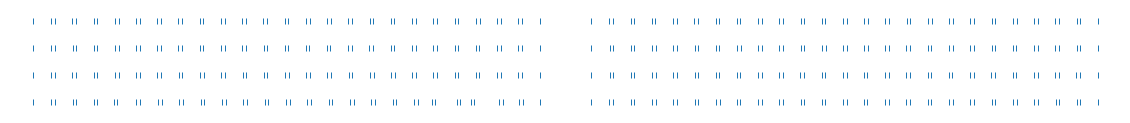

In [22]:
fig = plt.figure(figsize=(20, 2))
for i, crops in enumerate(crops_list):
    temp = pd.DataFrame(crops).to_numpy().flatten()
    sub = fig.add_subplot(4,2,i+1)
    sub.axis('off')
    sub.plot(temp,np.zeros_like(temp),'|')
plt.tight_layout
fig.subplots_adjust(wspace=.001, hspace=0)

##### Cropping Image and adding Individual Slices to new Array

In [23]:
strip_array_list = []

for i, cropped_image in enumerate(cropped_img_list):
    min_width = float('inf')
    strip_array = []

    #Get Each individual strip & the value of the minimum width
    for crop in crops_list[i]:
        front, back = crop
        min_width = min(min_width,back-front)
        strip_array.append(cropped_image[:,front:back])

    #Crop each strips width to the minimum width
    for i in range(len(strip_array)):
        strip_array[i] = strip_array[i][:,:min_width]

    strip_array_list.append(strip_array)


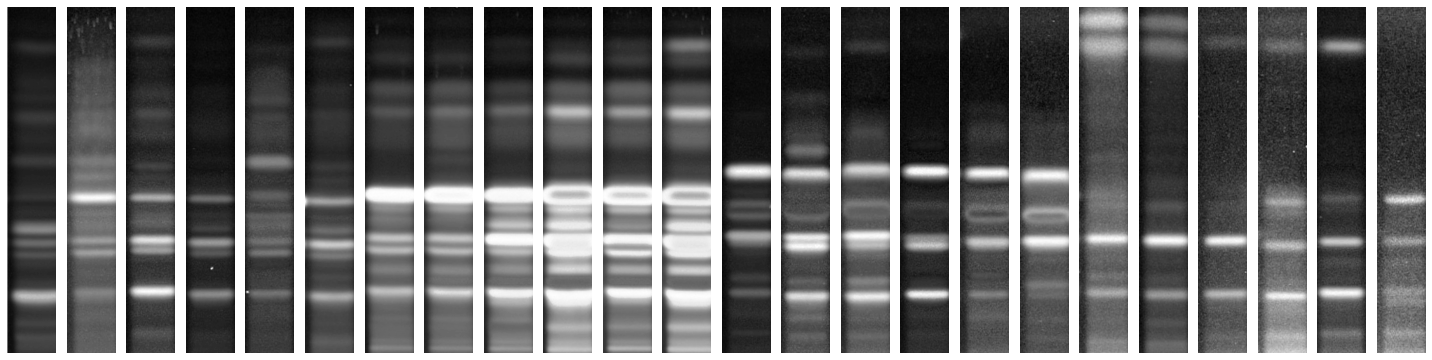

In [24]:
# Individual Print
strip_array = strip_array_list[1]
fig = plt.figure(figsize=(20, 10))
for i, strip in enumerate(strip_array):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    sub.imshow(strip,cmap='gray')
plt.tight_layout()

##### Transforming each Strip in array to a 1D Vector by getting average value of each row

In [25]:
strip_row_avg_list = []

for strip_array in strip_array_list:
    strip_row_avg = []

    for i, strip in enumerate(strip_array):
        strip_row_avg.append([])
        for row in strip:
            strip_row_avg[i].append(row.mean())

    strip_row_avg_list.append(strip_row_avg)

In [26]:
np.shape(strip_row_avg_list[0][0])

(1030,)

In [27]:
np.shape(np.transpose([strip_row_avg_list[0][i] for k in range(min_width)]))

(1030, 140)

#### Plotting arrays of average values to verify mean of each row

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

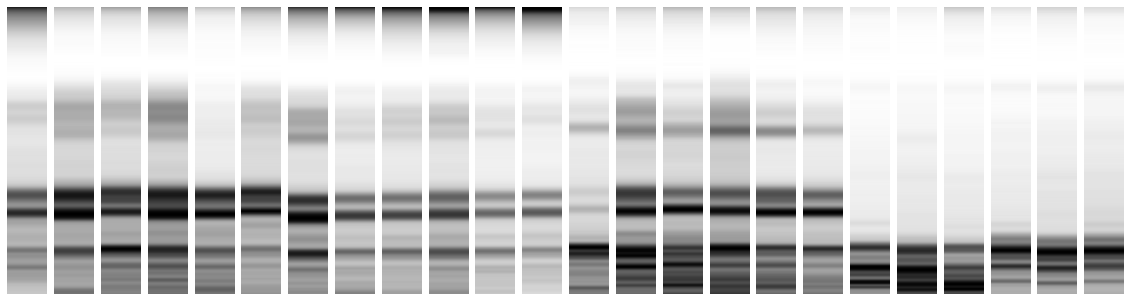

In [28]:
# Individual
fig = plt.figure(figsize=(20, 10)) 
for i in range(24):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    img = [strip_row_avg_list[-1][i] for k in range(min_width)]
    img = np.transpose(img)
    sub.imshow(img, cmap='gray')
plt.tight_layout

In [29]:
# 1 (GG): Rows 1 - 6 
# 2 (GI): Rows 7 - 12
# 3 (GU): Rows 13 - 18
# 4 (GE): Rows 19 - 21
# 5 (GL): Rows 22 - 24
map = {1:'GG',2:'GI',3:'GU',4:'GE',5:'GL'}
print(map[4])

GE


In [30]:
np.shape(strip_row_avg_list)

(8, 24, 1030)

In [31]:
np.shape(strip_row_avg_list[0])

(24, 1030)

##### Append Targets to feature array

In [32]:
for strip_row_avg in strip_row_avg_list:
    for i in range(6):
        # strip_row_avg[i].append(1)
        strip_row_avg[i] = np.append(strip_row_avg[i],1)
    for i in range(6,12):
        # strip_row_avg[i].append(2)
        strip_row_avg[i] = np.append(strip_row_avg[i],2)
    for i in range(12,18):
        # strip_row_avg[i].append(3)
        strip_row_avg[i] = np.append(strip_row_avg[i],3)
    for i in range(18,21):
        # strip_row_avg[i].append(4)
        strip_row_avg[i] = np.append(strip_row_avg[i],4)
    for i in range(21,24):
        # strip_row_avg[i].append(5)
        strip_row_avg[i] = np.append(strip_row_avg[i],5)

In [33]:
print(np.shape(strip_row_avg_list))

(8, 24, 1031)


In [34]:
print(pd.DataFrame(strip_row_avg_list[0]).shape)

(24, 1031)


In [35]:
# print(pd.DataFrame(strip_row_avg_list[0]))

#### Looping through Each Image's Strips and Training the model for Classification

In [36]:
accuracy = []
for i, strip_row_avg in enumerate(strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()
    
    #Set Model Parameters

    #l2, hinge, dual = True
    # model.set_params(random_state=101,
    #                 verbose=0,
    #                 max_iter=4500,
    #                 penalty='l2',
    #                 loss='hinge',
    #                 dual=True)

    #l1, squared_hinge, dual = False
    model.set_params(random_state=101,
                    verbose=1,
                    max_iter=4500,
                    penalty='l1',
                    loss='squared_hinge',
                    dual=False)

    # NOTE: Combinations including 'l1 + hinge' are not supported
    # NOTE: The Combination of 'l1 + squared_hinge' + 'dual = True' is not supported
    # NOTE: The Combination of 'l2 + hinge + dual = False' is not supported
    # NOTE: Remaining Options: [l1, squared_hinge, dual = False] or [l2, hinge, dual = True]
    
    # NOTE: Theoretically, Dual = False/True should yield the same results

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
    accuracy.append(round(model.score(df_feat,df_target),3))

    #Print Answers for Strips
    # answer = model.predict(np.array(df_feat))
    # print("Answers: "+str(answer))

print('\nAccuracy for Each Image: '+str(accuracy))

[LibLinear][LibLinear]

c:\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear][LibLinear]

c:\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear][LibLinear]

c:\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear][LibLinear]
Accuracy for Each Image: [0.75, 0.792, 0.875, 0.583, 0.708, 0.792, 0.917, 0.958]


c:\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\Python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


#### Results
##### l2, hinge, dual = True
    Accuracy for Each Image: [1.0, 1.0, 1.0, 1.0, 0.875, 0.958, 0.958, 1.0]

##### l1, squared_hinge, dual = False
    Accuracy for Each Image: [0.75, 0.792, 0.875, 0.583, 0.708, 0.792, 0.917, 0.958]

### Experimenting with Alternate Parameters

In [37]:
# Verifying values are w/n the 0 - 1 range
print(np.shape(strip_row_avg_list[0][0]))
print(max(strip_row_avg_list[0][0]))
print(min(strip_row_avg_list[0][0]))

(1031,)
1.0
0.05425029139433552


##### Calculate Min Value of C such that the models is guaranteed not to be empty

In [38]:
#Minimum C so that the model is guaranteed to not be empty
min_c_vals = []
for i, strip_row_avg in enumerate(strip_row_avg_list):
    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    min_c_vals.append(l1_min_c(df_feat,df_target).round(3))
print(min_c_vals)

[0.028, 0.028, 0.028, 0.028, 0.028, 0.028, 0.028, 0.028]


##### Messing w/ Coefficients and C

In [41]:
accuracy = []
for i, strip_row_avg in enumerate(strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()
    
    #Set Model Parameters

    #l2, hinge, dual = True
    # model.set_params(random_state=101,
    #                 verbose=0,
    #                 max_iter=4500,
    #                 penalty='l2',
    #                 loss='hinge',
    #                 dual=True,
    #                 C=.2)

    #l1, squared_hinge, dual = False
    model.set_params(random_state=101,
                    verbose=0,
                    max_iter=4500,
                    penalty='l1',
                    loss='squared_hinge',
                    dual=False,
                    C=.03)

    # NOTE: Combinations including 'l1 + hinge' are not supported
    # NOTE: The Combination of 'l1 + squared_hinge' + 'dual = True' is not supported

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
    accuracy.append(round(model.score(df_feat,df_target),3))

    #Print answers for each strip
    answer = model.predict(np.array(df_feat))
    print("Answers: "+str(answer))

    #Print coefficients
    # print("Coefficients for Strip "+str(i)+": "+str(model.coef_))
    print("Max Coef: "+str(np.max(model.coef_)))
    print("Min Coef: "+str(np.min(model.coef_)))
    print('\n')


print('\nAccuracy for Each Image: '+str(accuracy))


Strip 0: 0.25
Answers: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Max Coef: 0.0
Min Coef: 0.0



Strip 1: 0.25
Answers: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Max Coef: 0.0
Min Coef: 0.0



Strip 2: 0.25
Answers: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Max Coef: 0.0
Min Coef: 0.0



Strip 3: 0.25
Answers: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Max Coef: 0.0
Min Coef: 0.0



Strip 4: 0.25
Answers: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Max Coef: 0.0
Min Coef: 0.0



Strip 5: 0.25
Answers: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Max Coef: 0.0
Min Coef: 0.0



Strip 6: 0.25
Answers: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Max Coef: 0.0
Min Coef: 0.0



Strip 7: 0.25
Answers: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Max Co

##### Creating Pipeline Funcitionality
    Adding Standard Scalar
        Conclusion: Standard Scalar made Accuracy Significantly Worse

In [ ]:
accuracy = []
for i, strip_row_avg in enumerate(strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()
    
    #Set Model Parameters

    #l2, hinge, dual = True
    model.set_params(random_state=101,
                    verbose=0,
                    max_iter=4500,
                    penalty='l2',
                    loss='hinge',
                    dual=True)

    #l1, squared_hinge, dual = False
    # model.set_params(random_state=101,
    #                 verbose=0,
    #                 max_iter=4500,
    #                 penalty='l1',
    #                 loss='squared_hinge',
    #                 dual=False)

    # NOTE: Combinations including 'l1 + hinge' are not supported
    # NOTE: The Combination of 'l1 + squared_hinge' + 'dual = True' is not supported

    clf = make_pipeline(StandardScaler(), model)

    #Fit Model
    clf.fit(df_feat, df_target)

    #Print Score
    print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
    accuracy.append(round(model.score(df_feat,df_target),3))

    #Print answers for each strip
    answer = model.predict(np.array(df_feat))
    print("Answers: "+str(answer))

print('\nAccuracy for Each Image: '+str(accuracy))

##### Using SGDClassifier - allows for l1 & hinge combination

In [ ]:
accuracy = []
for i, strip_row_avg in enumerate(strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = SGDClassifier()
    
    #Set Model Parameters

    #l1, hinge
    model.set_params(random_state=101,
                    verbose=0,
                    max_iter=4500,
                    penalty='l1',
                    loss='hinge')

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
    accuracy.append(round(model.score(df_feat,df_target),3))

    answer = model.predict(np.array(df_feat))
    print("Answers: "+str(answer))

print('\nAccuracy for Each Image: '+str(accuracy))

## Grid Search on L1 Squared-Hinge Model

In [ ]:
accuracy = []
best_params = []

for i, strip_row_avg in enumerate(strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()
    
    #Set Model Parameters

    #l2, hinge, dual = True
    # model.set_params(random_state=101,
    #                 verbose=0,
    #                 max_iter=4500,
    #                 penalty='l2',
    #                 loss='hinge',
    #                 dual=True)

    #l1, squared_hinge, dual = False
    model.set_params(random_state=101,
                    verbose=0,
                    max_iter=4500,
                    penalty='l1',
                    loss='squared_hinge',
                    dual=False)

    # NOTE: Combinations including 'l1 + hinge' are not supported
    # NOTE: The Combination of 'l1 + squared_hinge' + 'dual = True' is not supported
    # NOTE: The Combination of 'l2 + hinge + dual = False' is not supported
    # NOTE: Remaining Options: [l1, squared_hinge, dual = False] or [l2, hinge, dual = True]
    
    # NOTE: Theoretically, Dual = False/True should yield the same results

    C=np.array([0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]) # Different C values
    tuned_parameters = {'C' : C} 

    grid = GridSearchCV(model,tuned_parameters,refit=True,verbose=0)

    #Train Model USING GRID SEARCH
    grid.fit(df_feat,df_target)

    #Print Score
    # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
    accuracy.append(round(grid.score(df_feat,df_target),3))

    #Print Answers for Strips
    answer = model.predict(np.array(df_feat))
    print("Answers: "+str(answer))

    #Print Best Params for Grid Search
    print("\nStrip "+str(i)+": "+str(grid.best_params_))
    best_params.append(grid.best_params_)

    break

print('\nAccuracy for Each Image: '+str(accuracy))
print('Best Params for Each Image: '+str(best_params))

##### Results of Grid Search
At 4500 Iterations
  * Accuracy for Each Image: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

  * Best Params for Each Image: [{'C': 10.0}, {'C': 1000.0}, {'C': 10.0}, {'C': 100.0}, {'C':   1000.0}, {'C': 10.0}, {'C': 100.0}, {'C': 10.0}]

At 100,000 Iterations (For Fun)
  * Accuracy for Each Image: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  
  * Best Params for Each Image: [{'C': 10.0}, {'C': 10000.0}, {'C': 100.0}, {'C': 100.0}, {'C': 10000.0}, {'C': 10.0}, {'C': 10000.0}, {'C': 10.0}]

## Grid Search on L2 Hinge Model

In [ ]:
accuracy = []
best_params = []

for i, strip_row_avg in enumerate(strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()
    
    #Set Model Parameters

    #l2, hinge, dual = True
    model.set_params(random_state=101,
                    verbose=0,
                    max_iter=4500,
                    penalty='l2',
                    loss='hinge',
                    dual=True)

    #l1, squared_hinge, dual = False
    # model.set_params(random_state=101,
    #                 verbose=0,
    #                 max_iter=4500,
    #                 penalty='l1',
    #                 loss='squared_hinge',
    #                 dual=False)

    # NOTE: Combinations including 'l1 + hinge' are not supported
    # NOTE: The Combination of 'l1 + squared_hinge' + 'dual = True' is not supported
    # NOTE: The Combination of 'l2 + hinge + dual = False' is not supported
    # NOTE: Remaining Options: [l1, squared_hinge, dual = False] or [l2, hinge, dual = True]
    
    # NOTE: Theoretically, Dual = False/True should yield the same results

    C=np.array([0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]) # Different C values
    tuned_parameters = {'C' : C} 

    grid = GridSearchCV(model,tuned_parameters,refit=True,verbose=0)

    #Train Model USING GRID SEARCH
    grid.fit(df_feat,df_target)

    #Print Score
    # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
    accuracy.append(round(grid.score(df_feat,df_target),3))

    #Print Answers for Strips
    # answer = model.predict(np.array(df_feat))
    # print("Answers: "+str(answer))

    #Print Best Params for Grid Search
    print("\nStrip "+str(i)+": "+str(grid.best_params_))
    best_params.append(grid.best_params_)

    # break

print('\nAccuracy for Each Image: '+str(accuracy))
print('Best Params for Each Image: '+str(best_params))

##### Results of Grid Search
At 4500 Iterations
  * Accuracy for Each Image: [1.0, 1.0, 1.0, 0.958, 0.875, 1.0, 0.958, 1.0]
  
  * Best Params for Each Image: [{'C': 10.0}, {'C': 10.0}, {'C': 10.0}, {'C': 10.0}, {'C': 10.0}, {'C': 10.0}, {'C': 10.0}, {'C': 1.0}]

At 100,000 Iterations (For Fun)
  * Accuracy for Each Image: [1.0, 1.0, 1.0, 1.0, 0.958, 1.0, 1.0, 1.0]
  * Best Params for Each Image: [{'C': 10.0}, {'C': 10.0}, {'C': 10.0}, {'C': 10.0}, {'C': 10.0}, {'C': 10.0}, {'C': 10.0}, {'C': 1.0}]

### Generating Confusion Matrix at Arbitrary C Value

Answers: [1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 4. 4. 4. 5. 5. 5.]


c:\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


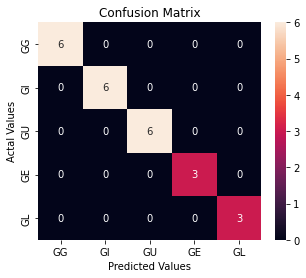

Answers: [1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 4. 4. 4. 5. 5. 5.]


c:\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


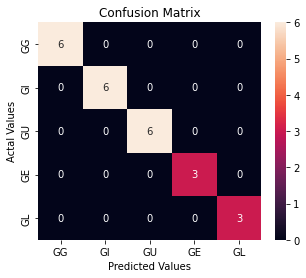

Answers: [1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 4. 4. 4. 5. 5. 5.]


c:\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


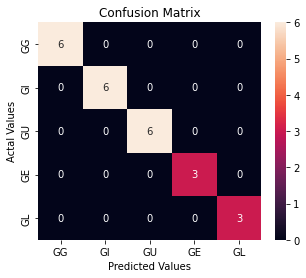

Answers: [1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 4. 4. 4. 5. 5. 5.]


c:\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


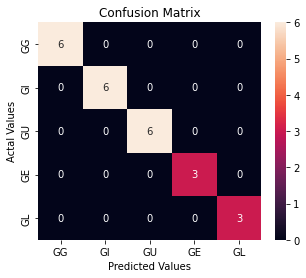

Answers: [1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 4. 4. 4. 5. 5. 5.]


c:\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


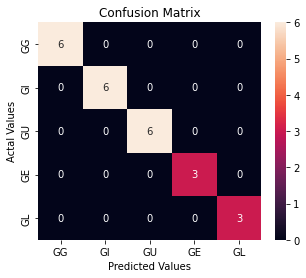

Answers: [1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 4. 4. 4. 5. 5. 5.]


c:\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


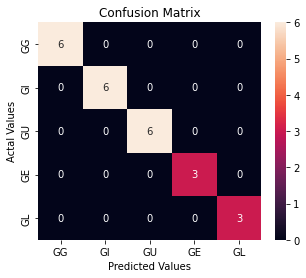

Answers: [1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 4. 4. 4. 5. 5. 5.]


c:\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


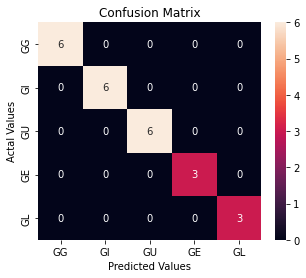

Answers: [1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 4. 4. 4. 5. 5. 5.]


c:\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


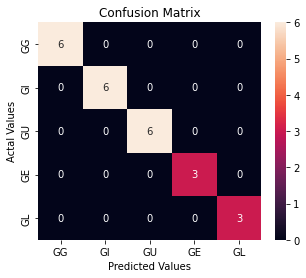


Accuracy for Each Image: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [58]:
accuracy = []
for i, strip_row_avg in enumerate(strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()
    
    #Set Model Parameters

    #l2, hinge, dual = True
    # model.set_params(random_state=101,
    #                 verbose=0,
    #                 max_iter=4500,
    #                 penalty='l2',
    #                 loss='hinge',
    #                 dual=True,
    #                 C=10)

    #l1, squared_hinge, dual = False
    model.set_params(random_state=101,
                    verbose=0,
                    max_iter=4500,
                    penalty='l1',
                    loss='squared_hinge',
                    dual=False,
                    C=10)

    # NOTE: Combinations including 'l1 + hinge' are not supported
    # NOTE: The Combination of 'l1 + squared_hinge' + 'dual = True' is not supported
    # NOTE: The Combination of 'l2 + hinge + dual = False' is not supported
    # NOTE: Remaining Options: [l1, squared_hinge, dual = False] 
    #                           or [l2, hinge, dual = True]
    #                           or [l2, squared_hinge, dual = True]
    
    # NOTE: Theoretically, Dual = False/True should yield the same results

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
    accuracy.append(round(model.score(df_feat,df_target),3))

    #Print Answers for Strips
    answer = model.predict(np.array(df_feat))
    print("Answers: "+str(answer))

    #Creating and Printing Confusion matrix
    cm = confusion_matrix(df_target,answer)
    cm_df = pd.DataFrame(cm, 
                        index = ['GG', 'GI', 'GU', 'GE', 'GL'],
                        columns = ['GG', 'GI', 'GU', 'GE', 'GL'])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

print('\nAccuracy for Each Image: '+str(accuracy))